# How to update graph state from nodes

This guide demonstrates how to define and update [state](../../concepts/low_level/#state) in LangGraph. We will demonstrate:

1. How to use state to define a graph's [schema](../../concepts/low_level/#schema)
2. How to use [reducers](../../concepts/low_level/#reducers) to control how state updates are processed.

We will use [messages](../../concepts/low_level/#messagesstate) in our examples. This represents a versatile formulation of state for many LLM applications. See our [concepts page](../../concepts/low_level/#working-with-messages-in-graph-state) for more detail.

## Setup

First, let's install langgraph:

In [ ]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
     <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for better debugging</p>
     <p style="padding-top: 5px;">
         Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM aps built with LangGraph — read more about how to get started in the <a href="https://docs.smith.langchain.com">docs</a>. 
     </p>
 </div>

## Example graph

### Define state
[State](../../concepts/low_level/#state) in LangGraph can be a `TypedDict`, `Pydantic` model, or dataclass. Below we will use `TypedDict`. See [this guide](../../how-tos/state-model) for detail on using Pydantic.

By default, graphs will have the same input and output schema, and the state determines that schema. See [this guide](../../how-tos/input_output_schema/) for how to define distinct input and output schemas.

Let's consider a simple example:

In [1]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict


class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

This state tracks a list of [message](https://python.langchain.com/docs/concepts/messages/) objects, as well as an extra integer field.

### Define graph structure

Let's build an example graph with a single node. Our [node](../../concepts/low_level/#nodes) is just a Python function that reads our graph's state and makes updates to it. The first argument to this function will always be the state:

In [2]:
from langchain_core.messages import AIMessage


def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("Hello!")

    return {"messages": messages + [new_message], "extra_field": 10}

This node simply appends a message to our message list, and populates an extra field.

!!! important

    Nodes should return updates to the state directly, instead of mutating the state.

Let's next define a simple graph containing this node. We use [StateGraph](../../concepts/low_level/#stategraph) to define a graph that operates on this state. We then use [add_node](../../concepts/low_level/#messagesstate) populate our graph.

In [3]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node(node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

LangGraph provides built-in utilities for visualizing your graph. Let's inspect our graph. See [this guide](../../how-tos/visualization) for detail on visualization.

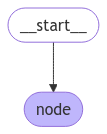

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In this case, our graph just executes a single node.

### Use graph

Let's proceed with a simple invocation:

In [5]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("Hi")]})
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}

Note that:

- We kicked off invocation by updating a single key of the state.
- We receive the entire state in the invocation result.

For convenience, we frequently inspect the content of [message objects](https://python.langchain.com/docs/concepts/messages/) via pretty-print:

In [6]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


## Process state updates with reducers

Each key in the state can have its own independent [reducer](../../concepts/low_level/#reducers) function, which controls how updates from nodes are applied. If no reducer function is explicitly specified then it is assumed that all updates to the key should override it.

For `TypedDict` state schemas, we can define reducers by annotating the corresponding field of the state with a reducer function.

In the earlier example, our node updated the `"messages"` key in the state by appending a message to it. Below, we add a reducer to this key, such that updates are automatically appended:

In [7]:
from typing_extensions import Annotated


def add(left, right):
    """Can also import `add` from the `operator` built-in."""
    return left + right


class State(TypedDict):
    # highlight-next-line
    messages: Annotated[list[AnyMessage], add]
    extra_field: int

Now our node can be simplified:

In [8]:
def node(state: State):
    new_message = AIMessage("Hello!")
    # highlight-next-line
    return {"messages": [new_message], "extra_field": 10}

In [10]:
from langgraph.graph import START


graph = StateGraph(State).add_node(node).add_edge(START, "node").compile()

result = graph.invoke({"messages": [HumanMessage("Hi")]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


### MessagesState

In practice, there are additional considerations for updating lists of messages:

- We may wish to update an existing message in the state.
- We may want to accept short-hands for [message formats](../../concepts/low_level/#using-messages-in-your-graph), such as [OpenAI format](https://python.langchain.com/docs/concepts/messages/#openai-format).

LangGraph includes a built-in reducer `add_messages` that handles these considerations:

In [11]:
from langgraph.graph.message import add_messages


class State(TypedDict):
    # highlight-next-line
    messages: Annotated[list[AnyMessage], add_messages]
    extra_field: int


def node(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "extra_field": 10}


graph = StateGraph(State).add_node(node).set_entry_point("node").compile()

In [12]:
# highlight-next-line
input_message = {"role": "user", "content": "Hi"}

result = graph.invoke({"messages": [input_message]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


This is a versatile representation of state for applications involving [chat models](https://python.langchain.com/docs/concepts/chat_models/). LangGraph includes a pre-built `MessagesState` for convenience, so that we can have:

In [13]:
from langgraph.graph import MessagesState


class State(MessagesState):
    extra_field: int

## Next steps

- Continue with the [Graph API Basics](../../how-tos/#graph-api-basics) guides.
- See more detail on [state management](../../how-tos/#state-management).